In [87]:
import cv2
import mediapipe as mp
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [88]:
import cv2
import mediapipe as mp
import numpy as np
import os
import json

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to check if the pivot is initiated from the ball of the foot
def is_pivot_initiated(ball_of_foot, heel):
    """
    Determines if the pivot is initiated from the ball of the foot by checking the
    relative position of the ball of the foot and the heel.
    The condition is met if the ball of the foot remains grounded while the heel lifts.
    """
    ball_x, ball_y = ball_of_foot
    heel_x, heel_y = heel

    # Pivot condition: ball of the foot stays stable while heel moves upwards
    return heel_y > ball_y + 0.02  # Small threshold to detect heel lift

# Paths for the discus throwing videos and keypoints storage
stage_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage2/videos"
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage2/keypoints"

# Ensure keypoints folder exists
os.makedirs(keypoints_folder, exist_ok=True)

for file in os.listdir(stage_path):
    if file.endswith(".mp4"):
        video_file_path = os.path.join(stage_path, file)
        cap = cv2.VideoCapture(video_file_path)

        keypoints_data = []  # Store keypoints for this video

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to RGB for MediaPipe processing
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result = pose.process(frame_rgb)

            if result.pose_landmarks:
                landmarks = result.pose_landmarks.landmark

                # Extract relevant keypoints for pivot analysis (right foot)
                right_ball_of_foot = [landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].x,
                                      landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y]
                right_heel = [landmarks[mp_pose.PoseLandmark.RIGHT_HEEL].x,
                              landmarks[mp_pose.PoseLandmark.RIGHT_HEEL].y]

                # Check if pivot is initiated from the ball of the foot
                pivot_initiated = is_pivot_initiated(right_ball_of_foot, right_heel)

                # Store data for this frame with standard Python booleans and float conversion
                keypoints_data.append({
                    "frame": int(cap.get(cv2.CAP_PROP_POS_FRAMES)),
                    "pivot_initiated": bool(pivot_initiated),
                    "right_ball_of_foot": [float(coord) for coord in right_ball_of_foot],
                    "right_heel": [float(coord) for coord in right_heel]
                })

        # Release the video
        cap.release()

        # Save keypoints to the keypoints folder
        json_filename = os.path.splitext(file)[0] + "_keypoints.json"
        json_path = os.path.join(keypoints_folder, json_filename)
        with open(json_path, "w") as json_file:
            json.dump(keypoints_data, json_file, indent=4)

print("Pivot initiation analysis complete! JSON files saved in 'keypoints' folder.")

I0000 00:00:1737670963.302125 11655019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737670963.360474 11983640 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737670963.373653 11983645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Pivot initiation analysis complete! JSON files saved in 'keypoints' folder.


In [89]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Path to the keypoints folder for pivot initiation analysis
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage2/keypoints"

# Lists to store sequences and labels
sequences = []
labels = []

# Process keypoint JSON files
for file in os.listdir(keypoints_folder):
    if file.endswith("_keypoints.json"):
        file_path = os.path.join(keypoints_folder, file)
        with open(file_path, "r") as f:
            data = json.load(f)

        # Extract pivot initiation indicators across all frames
        pivot_data = [
            [int(frame["pivot_initiated"])]  # Convert boolean to int (False -> 0, True -> 1)
            for frame in data
        ]
        sequences.append(pivot_data)

        # Extract label from filename (assumes label is the first part of filename)
        try:
            label = float(file.split("_")[0])  # Modify if filename structure differs
        except ValueError:
            print(f"Warning: Unable to extract label from {file}")
            continue

        labels.append(label)

# Pad sequences to ensure uniform input shape
if sequences:
    max_len = max(len(seq) for seq in sequences)
    sequences = pad_sequences(sequences, maxlen=max_len, padding='post', dtype='float32')
    labels = np.array(labels)

    print(f"Loaded {len(sequences)} sequences with labels.")
else:
    print("No sequences found in the keypoints folder.")

Loaded 15 sequences with labels.


In [90]:
def augment_data(sequence):
    augmented_sequences = []

    # Original
    augmented_sequences.append(sequence)

    # Mirrored (flip angles horizontally)
    mirrored = -sequence
    augmented_sequences.append(mirrored)

    # Rotation (add a small angle offset)
    rotated = sequence + np.random.uniform(-10, 10, size=sequence.shape)
    augmented_sequences.append(rotated)

    # Noise (add random Gaussian noise)
    noisy = sequence + np.random.normal(0, 0.05, size=sequence.shape)
    augmented_sequences.append(noisy)

    # Scaled (adjust by a small percentage)
    scaled = sequence * np.random.uniform(0.9, 1.1)
    augmented_sequences.append(scaled)

    return augmented_sequences

augmented_sequences = []
augmented_labels = []

for seq, label in zip(sequences, labels):
    augmented = augment_data(seq)
    augmented_sequences.extend(augmented)
    augmented_labels.extend([label] * len(augmented))

augmented_sequences = np.array(augmented_sequences)
augmented_labels = np.array(augmented_labels)

print(f"Augmented dataset size: {len(augmented_sequences)}")

Augmented dataset size: 75


In [91]:
# Ensure consistent sequence length before splitting
max_length = max(len(seq) for seq in augmented_sequences)
augmented_sequences = pad_sequences(augmented_sequences, maxlen=max_length, padding='post', dtype='float32')

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    augmented_sequences, augmented_labels, test_size=4/17, random_state=42
)

# Correct the reshaping based on the actual shape
num_timesteps = X_train.shape[1] // 2  # Assuming 2 features per timestep
X_train = X_train.reshape((X_train.shape[0], num_timesteps, 2))
X_val = X_val.reshape((X_val.shape[0], num_timesteps, 2))

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 57, Validation samples: 18


In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define enhanced LSTM model
model = Sequential([
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 2))),
    Dropout(0.5),

    Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
    Dropout(0.4),

    Bidirectional(LSTM(32, activation='tanh', return_sequences=False)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output: Regression score
])

# Compile the model with a reduced learning rate for better convergence
model.compile(optimizer=Adam(learning_rate=0.00075), loss='mse', metrics=['mae'])

print(model.summary())


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_15                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [93]:
# Train the LSTM model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=700,  # You can adjust based on convergence
    batch_size=12,  # Smaller batch size for augmented data
    verbose=1
)

Epoch 1/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.5908 - mae: 0.6337 - val_loss: 0.3422 - val_mae: 0.4220
Epoch 2/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3817 - mae: 0.5018 - val_loss: 0.2391 - val_mae: 0.4324
Epoch 3/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2878 - mae: 0.4804 - val_loss: 0.3000 - val_mae: 0.4940
Epoch 4/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2391 - mae: 0.4388 - val_loss: 0.2957 - val_mae: 0.5046
Epoch 5/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2024 - mae: 0.4023 - val_loss: 0.2620 - val_mae: 0.4953
Epoch 6/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2049 - mae: 0.4167 - val_loss: 0.2513 - val_mae: 0.4852
Epoch 7/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1931 - mae: 0.4026 - val_loss: 0.2703 - val_mae: 0.4992
Epoch 8/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2037 - mae: 0.4174 - val_loss: 0.2689 - val_mae: 0.4946
Epoch 9/700
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2241 - mae:

In [94]:
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 0.3456, Validation MAE: 0.5178


In [95]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Print predictions vs. actual
for i, pred in enumerate(predictions):
    print(f"Predicted: {pred[0]:.2f}, Actual: {y_val[i]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Predicted: 0.55, Actual: 0.00
Predicted: 0.00, Actual: 0.00
Predicted: 0.55, Actual: 1.00
Predicted: 0.55, Actual: 0.00
Predicted: 0.55, Actual: 1.00
Predicted: 0.55, Actual: 0.00
Predicted: 0.75, Actual: 0.00
Predicted: 0.92, Actual: 1.00
Predicted: 0.55, Actual: 0.50
Predicted: 0.55, Actual: 0.00
Predicted: 0.55, Actual: 0.00
Predicted: 0.51, Actual: 0.00
Predicted: 0.55, Actual: 1.00
Predicted: 1.02, Actual: 0.00
Predicted: 0.55, Actual: 1.00
Predicted: 0.02, Actual: 1.00
Predicted: 0.55, Actual: 1.00
Predicted: 0.93, Actual: 0.00


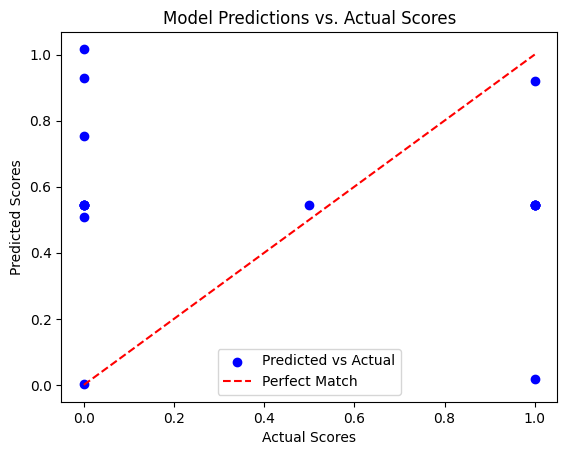

In [96]:
# Scatter plot of predictions vs. actual
import matplotlib.pyplot as plt

plt.scatter(y_val, predictions, c='blue', label='Predicted vs Actual')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Match')  # Reference line
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Model Predictions vs. Actual Scores')
plt.legend()
plt.show()

In [97]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to check if pivot is performed flat toward circle center
def is_flat_pivot(foot_toe, foot_heel):
    """
    Determines if the pivot is performed flat by analyzing the relative position
    of the toe and heel.
    Conditions:
    - The toe and heel should have minimal vertical displacement.
    - The foot should maintain a stable position on the ground.
    """
    toe_x, toe_y = foot_toe
    heel_x, heel_y = foot_heel

    # Flat pivot condition: minimal vertical displacement and stable positioning
    pivot_detected = abs(toe_y - heel_y) < 0.02 and abs(toe_x - heel_x) < 0.05
    return pivot_detected

# Path for the new test video
new_video_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage3/test_videos/1_user5.mp4"

# Extract keypoints for the new video
new_keypoints = []
cap = cv2.VideoCapture(new_video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB for MediaPipe processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(frame_rgb)

    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark

        # Extract keypoints for pivot analysis
        left_toe = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x, landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y]
        left_heel = [landmarks[mp_pose.PoseLandmark.LEFT_HEEL].x, landmarks[mp_pose.PoseLandmark.LEFT_HEEL].y]

        right_toe = [landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].x, landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y]
        right_heel = [landmarks[mp_pose.PoseLandmark.RIGHT_HEEL].x, landmarks[mp_pose.PoseLandmark.RIGHT_HEEL].y]

        # Check for flat pivot on both feet
        left_pivot = is_flat_pivot(left_toe, left_heel)
        right_pivot = is_flat_pivot(right_toe, right_heel)

        # Store the binary values (0 or 1) for analysis
        new_keypoints.append([int(left_pivot), int(right_pivot)])

cap.release()

# Pad the sequence to match training input length
max_seq_length = X_train.shape[1]  # Ensure it's the same length used during training
new_keypoints_padded = pad_sequences([new_keypoints], maxlen=max_seq_length, padding='post', dtype='float32')

# Reshape to match model input (samples, timesteps, features)
new_keypoints_padded = new_keypoints_padded.reshape((new_keypoints_padded.shape[0], new_keypoints_padded.shape[1], 2))

# Predict score for the new video
predicted_score = model.predict(new_keypoints_padded)
print(f"Predicted Score: {predicted_score[0][0]:.2f}")

I0000 00:00:1737671131.192155 11655019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737671131.264387 12035729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737671131.286229 12035729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
Predicted Score: 1.13


In [98]:
print(X_train.shape[1])

40


In [99]:
def classify_score(prediction):
    """Classify the prediction into 0, 0.5, or 1 based on thresholds."""
    if prediction >= 0.7:
        return 1.0
    elif prediction >= 0.4:
        return 0.5
    else:
        return 0.0

In [100]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Apply classification logic
classified_predictions = [classify_score(pred[0]) for pred in predictions]

# Print classified predictions vs actual scores
for i, (pred, actual) in enumerate(zip(classified_predictions, y_val)):
    print(f"Classified: {pred}, Actual: {actual}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Classified: 0.5, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 0.5, Actual: 1.0
Classified: 0.5, Actual: 0.0
Classified: 0.5, Actual: 1.0
Classified: 0.5, Actual: 0.0
Classified: 1.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 0.5, Actual: 0.5
Classified: 0.5, Actual: 0.0
Classified: 0.5, Actual: 0.0
Classified: 0.5, Actual: 0.0
Classified: 0.5, Actual: 1.0
Classified: 1.0, Actual: 0.0
Classified: 0.5, Actual: 1.0
Classified: 0.0, Actual: 1.0
Classified: 0.5, Actual: 1.0
Classified: 1.0, Actual: 0.0


In [101]:
import tensorflow.keras.backend as K

def weighted_mse(y_true, y_pred):
    """Weighted Mean Squared Error to prioritize true negatives."""
    weights = K.switch(y_true < 0.70, 2.0, 1.0)  # Weight true negatives higher
    return K.mean(weights * K.square(y_true - y_pred))

In [102]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=weighted_mse, metrics=['mae'])

In [103]:
# Predict and classify scores
classified_predictions = [classify_score(pred[0]) for pred in model.predict(X_val)]

# Evaluate accuracy of classification
correct = sum(1 for pred, actual in zip(classified_predictions, y_val) if pred == actual)
accuracy = correct / len(y_val)

print(f"Classification Accuracy: {accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Classification Accuracy: 0.17


In [104]:
model.save("/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage2/models/discus_stage2.keras")